In [1]:
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#### 1. Align consecutive frames
    a. Lucas Kanade or Point Correspondences, you choose
    b. Create a transformation matrix for every two consecutive frames
    c. Debug: Use synthetic videos: no motion, simple translation,

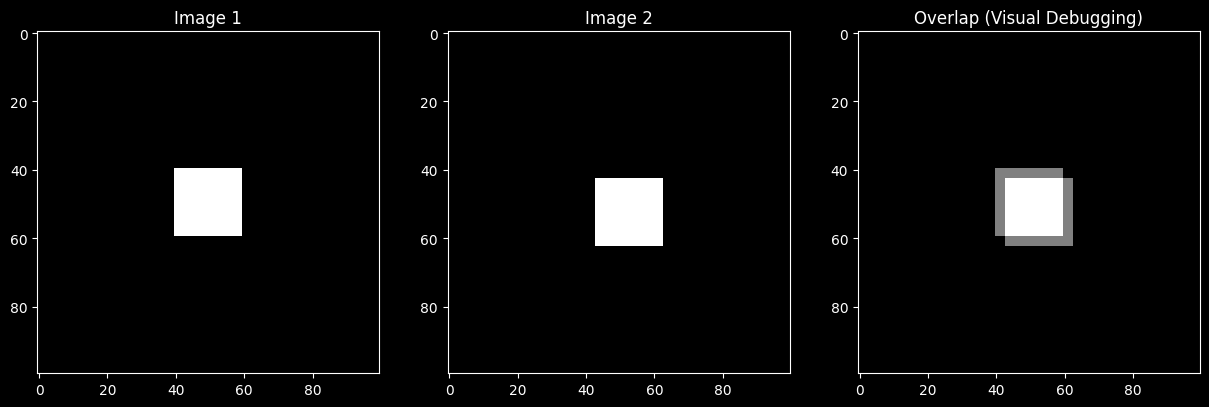

In [15]:
im1 = np.zeros((100, 100))
im1[40:60, 40:60] = 1
im2 = np.zeros((100, 100))
u,v = 3, 3
im2[40+u:60+v, 40+u:60+v] = 1 # Shifted by 1 pixel

# 2. Plotting side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns
# Image 1
axes[0].imshow(im1, cmap='gray')
axes[0].set_title("Image 1")
# Image 2
axes[1].imshow(im2, cmap='gray')
axes[1].set_title("Image 2")
# Overlap
axes[2].imshow(im1 + im2, cmap='gray')
axes[2].set_title("Overlap (Visual Debugging)")

# axes.imshow(im1 + im2, cmap='gray')
plt.show()

In [10]:
u, v = ex4.lucas_kanade_step(im1, im2, window_size=3)
print(f"Calculated shift: u={u}, v={v}")

Inside the function!
Calculated shift: u=0, v=0


#### 2. Stabilize Rotations & Y translations
    a. Debug: Use synthetic videos: no motion, simple translation, rotation...
    b. Create - warp frames to get a stable video (only horizontal motion)

#### 3. Use motion composition to align all frames to same coordinates.
    a. Compute canvas size from motion matrices
    b. Create - paste aligned frames into canvas on top of each other


#### 4. Create mosaic by pasting strips using correct width & location
    a. Start with synthetic videos at constant translation & no rotation...
    b. Back Warping from canvas to frame...


#### 5. Set convergence point (With no setting - this is infinity)
    a. Depth point that does not move between mosaics